<a href="https://colab.research.google.com/github/Khyatidaksha15/RAG/blob/main/rag_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    #!pip install -U torch
    # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.


In [2]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "/content/BARC NEWSLETTER.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File /content/BARC NEWSLETTER.pdf exists.


In [3]:
# Requires !pip install PyMuPDF, see: https://github.com/pymupdf/pymupdf
import fitz # (pymupdf, found this is better than pypdf for our use case, note: licence is AGPL-3.0, keep that in mind if you want to use any code commercially)
from tqdm.auto import tqdm # for progress bars, requires !pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number + 1,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': 1,
  'page_char_count': 344,
  'page_word_count': 63,
  'page_sentence_count_raw': 2,
  'page_token_count': 86.0,
  'text': 'Optimum HI to H  Conversion 2 Hydrogen Recombiner The official bi-monthly publication of Bhabha Atomic Research Centre BARC  July-August 2023 ISSN: 0976-2108 newsletter Fire Hazard Analysis RBI Governor visits BARC W I T H E M I M E N T P E R S O N S Networking Igniting young minds CFD MATERIALS SCIENCE CHEMICAL ENGG. SAFETY applications in 2'},
 {'page_number': 2,
  'page_char_count': 585,
  'page_word_count': 104,
  'page_sentence_count_raw': 35,
  'page_token_count': 146.25,
  'text': 'Dr. S. Adhikari Design & Creative Work Shri Dinesh J. Vaidya Shri Madhav N Newsletter Committee Chairman  Dr. A.P . Tiwari Member Secretary &  Coordination Shri Madhav N Members Dr. A.K. Nayak Dr. G. Sugilal Dr. V .H. Patankar Dr. (Smt.) B.K. Sapra Dr. L.M. Pant Dr. Ranjan Mittal Dr. (Smt.) S. Mukhopadhyay Dr. (Smt.) S. Mukhopadhyay Dr. K.P . Muthe Dr. V . Sudar

In [4]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 46,
  'page_char_count': 2085,
  'page_word_count': 300,
  'page_sentence_count_raw': 36,
  'page_token_count': 521.25,
  'text': '[17] Sharma, P.K. “The new combined fire confinement and fire  influence approach of fire hazard analysis/design safety margin  evaluation for NPPs and reprocessing facilities”. in: Technical Meeting  on the Probabilistic Safety Assessment Framework for External Events,  3–6 August 2015, IAEA Headquarters, Vienna, Austria, 2015. [18] Determination of safety distances, IGC Doc 75/07/E, European  industrial gases association AISBL. [19] API RP 581, Risk-based inspection technology, American  Petroleum Institute (API). [20] Design basis events for pressurised heavy water reactor, AERB  safety guide No. AERB/SG/D-5. [21] European Parliament and Council. Directive 1999/92/EC of the  16 December 1999 on minimum requirements for improving the  safety and health protection of workers potentially at risk from  explosive atmospheres. Official Journal

In [5]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,1,344,63,2,86.00,Optimum HI to H Conversion 2 Hydrogen Recombi...
1,2,585,104,35,146.25,Dr. S. Adhikari Design & Creative Work Shri Di...
2,3,3793,712,27,948.25,am glad to write the foreword for this themati...
3,4,2167,345,26,541.75,"3 FOREWORD: K. T. Shenoy, Director, Chemical E..."
4,5,110,25,1,27.50,BARC FOUNDER’S DAY 2023 SPECIAL ISSUE forthcom...


In [6]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,66.00,66.00,66.00,66.00,66.00
mean,33.50,2906.17,540.21,26.94,726.54
std,19.20,1745.21,330.81,22.41,436.30
min,1.00,34.00,5.00,1.00,8.50
25%,17.25,1813.25,307.25,13.50,453.31
50%,33.50,2789.00,514.00,23.50,697.25
75%,49.75,3799.00,752.00,33.75,949.75
max,66.00,6912.00,1464.00,130.00,1728.00


In [7]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/66 [00:00<?, ?it/s]

In [9]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 43,
  'page_char_count': 2725,
  'page_word_count': 502,
  'page_sentence_count_raw': 18,
  'page_token_count': 681.25,
  'text': 'volume between Lower Explosive Limit (LEL) and Upper  3 Explosive Limit (UEL) for top release (Fig.4) is less than 0.1 m   and if ignited may produce small pressure and thermal effect  which is insignificant. Design Basis Leak (DBL) of Biogas and Liquid Petroleum  Gas (LPG) for Potential use in Hospital Kitchen   LES CFD analysis (using Navier-Stokes equations) of  hospital kitchen has been carried out considering design basis  leak of biogas and LPG [25]. Biogas being the lighter than air  makes a buoyant plume and tries to move upwards and strikes  with the ceiling and spreads. However, LPG being heavier than  air, makes a dense gas dispersion structures and tries to make  a cloud in the lower portion of the enclosure. It was found that  the volumetric concentration remains less than 5% for biogas  release. However, the volumetric concent

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,66.00,66.00,66.00,66.00,66.00,66.00
mean,33.50,2906.17,540.21,26.94,726.54,20.88
std,19.20,1745.21,330.81,22.41,436.30,13.91
min,1.00,34.00,5.00,1.00,8.50,1.00
25%,17.25,1813.25,307.25,13.50,453.31,11.00
50%,33.50,2789.00,514.00,23.50,697.25,20.50
75%,49.75,3799.00,752.00,33.75,949.75,30.00
max,66.00,6912.00,1464.00,130.00,1728.00,74.00


In [11]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/66 [00:00<?, ?it/s]

In [12]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 32,
  'page_char_count': 2793,
  'page_word_count': 830,
  'page_sentence_count_raw': 32,
  'page_token_count': 698.25,
  'text': 'taking it out through 3 outlets outlets. Multiple inlets and  outlets also increased the number of vortexes in the glovebox  which enhanced the mixing and improved the purging  efficiency. The introduction of a rotating fan in the glovebox  further enhanced the efficiency of the purging by improving the  mixing, it reduced the purging requirement by ~50 % from the  initial configuration having one inlet and outlet. References  [1]  M. Rentetzi, “Determining Nuclear Fingerprints: Glove Boxes,  Radiation Protection, and the International Atomic Energy Agency”,  Endeavour, 41 (2017) 39-50. [2]   K. Tokumitsu, H. Fujimoto, A. Mabuchi, T. Kasuh, “High capacity  carbon anode for Li-ion battery: A theoretical explanation”, Carbon, 37  (1999) 1599-1605. [3]   N. Vahdat, J.S. Johnson, A. Neidhardt, J. Cheng, D. Weitzman,  “Permeation of Chemicals Th

In [13]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,66.00,66.00,66.00,66.00,66.00,66.00,66.00
mean,33.50,2906.17,540.21,26.94,726.54,20.88,2.59
std,19.20,1745.21,330.81,22.41,436.30,13.91,1.35
min,1.00,34.00,5.00,1.00,8.50,1.00,1.00
25%,17.25,1813.25,307.25,13.50,453.31,11.00,2.00
50%,33.50,2789.00,514.00,23.50,697.25,20.50,2.50
75%,49.75,3799.00,752.00,33.75,949.75,30.00,3.00
max,66.00,6912.00,1464.00,130.00,1728.00,74.00,8.00


In [14]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/66 [00:00<?, ?it/s]

171

In [15]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 46,
  'sentence_chunk': 'Joint Army-Navy- NASA-Air Force (JANNAF) Combustion Conference, 2014. https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/201500025 96.pdf [27] Web: https://www.fema.gov/media-library-data/20130726- 1455-20490-7465/ fema426_ch4.pdf. 46 BARC newsletter     July-August 2023 R&D in  CFD',
  'chunk_char_count': 286,
  'chunk_word_count': 28,
  'chunk_token_count': 71.5}]

In [16]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,171.00,171.00,171.00,171.00
mean,31.94,1095.56,182.99,273.89
std,16.34,525.94,95.62,131.49
min,1.00,15.00,5.00,3.75
25%,19.00,715.00,122.00,178.75
50%,32.00,1200.00,193.00,300.00
75%,45.00,1486.50,237.50,371.62
max,66.00,2453.00,571.00,613.25


In [17]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9.25 | Text: Recombiner Injection pipe R&D in  CFD
Chunk token count: 3.75 | Text: 2 2 R&D in  CFD
Chunk token count: 26.75 | Text: BARC FOUNDER’S DAY 2023 SPECIAL ISSUE forthcoming issue C O N T E N T S July-August 2023 BARC newsletter  5
Chunk token count: 8.5 | Text: This page intentionally left blank
Chunk token count: 21.5 | Text: Dr. A. K. Tyagi 2. Dr. Nafees Ahmed V. 3. Smt. Deepa Thomas 4. Dr. Atindra M. Banerjee


In [18]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 1,
  'sentence_chunk': 'Optimum HI to H Conversion 2 Hydrogen Recombiner The official bi-monthly publication of Bhabha Atomic Research Centre BARC July-August 2023 ISSN: 0976-2108 newsletter Fire Hazard Analysis RBI Governor visits BARC W I T H E M I M E N T P E R S O N S Networking Igniting young minds CFD MATERIALS SCIENCE CHEMICAL ENGG. SAFETY applications in 2',
  'chunk_char_count': 342,
  'chunk_word_count': 61,
  'chunk_token_count': 85.5},
 {'page_number': 2,
  'sentence_chunk': 'Dr. S. Adhikari Design & Creative Work Shri Dinesh J. Vaidya Shri Madhav N Newsletter Committee Chairman Dr. A. P . Tiwari Member Secretary & Coordination Shri Madhav N Members Dr. A. K. Nayak Dr. G. Sugilal Dr. V . H. Patankar Dr. (Smt.)B. K. Sapra Dr. L. M. Pant Dr. Ranjan Mittal Dr. (Smt.)S. Mukhopadhyay Dr. (Smt.)S. Mukhopadhyay Dr. K. P . Muthe Dr. V . Sudarsan Dr. A. V . S. S. N. Rao Dr. S. R. Shimjith Dr. Sandip Basu Dr. Pranesh Sengupta Dr. R. Tripathi Editorial Assistant Assoc

In [19]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

In [20]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447799e-02 -4.51087346e-03 -4.98481654e-03  6.55444637e-02
 -9.87675134e-03  2.72835009e-02  3.66426669e-02 -3.30220396e-03
  8.50083586e-03  8.24953057e-03 -2.28497051e-02  4.02430259e-02
 -5.75200766e-02  6.33692369e-02  4.43207435e-02 -4.49507199e-02
  1.25284335e-02 -2.52012145e-02 -3.55292484e-02  1.29559236e-02
  8.67022295e-03 -1.92917492e-02  3.55632650e-03  1.89506095e-02
 -1.47128282e-02 -9.39843431e-03  7.64171127e-03  9.62186884e-03
 -5.98929124e-03 -3.90169173e-02 -5.47823943e-02 -5.67457918e-03
  1.11644939e-02  4.08067033e-02  1.76319077e-06  9.15296283e-03
 -8.77259858e-03  2.39383057e-02 -2.32784543e-02  8.04999769e-02
  3.19176316e-02  5.12598688e-03 -1.47708477e-02 -1.62524693e-02
 -6.03213198e-02 -4.35689241e-02  4.51211818e-02 -1.79053899e-02
  2.63367314e-02 -3.47866863e-02 -8.89175665e-03 -5.47674857e-02
 -1.24372598e-02 -2.38606799e-02  8.33496526e-02  5.71242087e-02
  1.13328611e-02 -1.49594182e-02  9.2037

In [21]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [22]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/163 [00:00<?, ?it/s]

CPU times: user 5.14 s, sys: 206 ms, total: 5.35 s
Wall time: 6.52 s


In [23]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [24]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 3.47 s, sys: 15.6 ms, total: 3.48 s
Wall time: 3.39 s


tensor([[-0.0218, -0.0017,  0.0321,  ...,  0.0123, -0.0586,  0.0043],
        [ 0.0496, -0.0501, -0.0057,  ...,  0.0335, -0.0422, -0.0454],
        [-0.0625, -0.0307, -0.0037,  ..., -0.0123,  0.0363,  0.0218],
        ...,
        [ 0.0759,  0.0073, -0.0247,  ...,  0.0188, -0.0150,  0.0184],
        [ 0.0464,  0.0456, -0.0216,  ...,  0.0108, -0.0042, -0.0007],
        [-0.0244, -0.0470, -0.0106,  ...,  0.0133, -0.0539, -0.0116]],
       device='cuda:0')

In [25]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df3.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [26]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Optimum HI to H Conversion 2 Hydrogen Recombin...,342,61,85.50,[-2.17770375e-02 -1.74682378e-03 3.21390368e-...
1,2,Dr. S. Adhikari Design & Creative Work Shri Di...,588,107,147.00,[ 4.96376306e-02 -5.01372367e-02 -5.74256247e-...
2,3,am glad to write the foreword for this themati...,1698,242,424.50,[-6.24868460e-02 -3.06687690e-02 -3.69447563e-...
3,3,"Further, the number of such articles increased...",1485,241,371.25,[-5.07761650e-02 -2.96857394e-02 -2.95373965e-...
4,3,Special thanks to SIRD Editorial Team for thei...,504,125,126.00,[-1.63238440e-02 6.28097216e-03 -6.39193412e-...


In [27]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df3.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([163, 768])

In [28]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,Optimum HI to H Conversion 2 Hydrogen Recombin...,342,61,85.50,"[-0.0217770375, -0.00174682378, 0.0321390368, ..."
1,2,Dr. S. Adhikari Design & Creative Work Shri Di...,588,107,147.00,"[0.0496376306, -0.0501372367, -0.00574256247, ..."
2,3,am glad to write the foreword for this themati...,1698,242,424.50,"[-0.062486846, -0.030668769, -0.00369447563, 0..."
3,3,"Further, the number of such articles increased...",1485,241,371.25,"[-0.050776165, -0.0296857394, -0.0295373965, 0..."
4,3,Special thanks to SIRD Editorial Team for thei...,504,125,126.00,"[-0.016323844, 0.00628097216, -0.00639193412, ..."


In [29]:
embeddings[0]

tensor([-2.1777e-02, -1.7468e-03,  3.2139e-02, -4.1670e-02, -2.2523e-02,
         1.6032e-02, -2.3184e-02,  2.5809e-02,  8.4373e-02, -4.9120e-02,
        -7.4768e-02,  2.0301e-02,  3.6562e-02,  4.4997e-02, -9.9520e-03,
         8.9224e-03,  2.4558e-02, -1.0850e-02, -3.6853e-02, -2.7080e-02,
         3.1666e-02,  5.7692e-02, -3.4648e-02,  6.4820e-02, -6.1498e-02,
         5.1005e-02, -6.4064e-03,  3.3503e-03,  3.4087e-02, -6.0616e-02,
         2.9918e-02,  3.1297e-02,  1.7211e-02,  2.2604e-02,  2.1726e-06,
        -5.1849e-02,  3.5689e-02,  1.1749e-02,  6.4304e-03, -3.8716e-02,
         5.6661e-02,  6.5516e-04, -6.2707e-02,  8.9932e-03, -2.3757e-03,
         2.9596e-02, -5.4390e-02, -3.7749e-02, -6.9898e-04, -1.6493e-02,
        -1.6635e-02, -4.5841e-02, -2.3009e-02, -1.7843e-02,  4.1468e-02,
        -3.2095e-02,  7.0221e-03,  2.0735e-02, -2.0716e-02, -1.2739e-02,
        -6.7171e-03,  2.1873e-02, -6.0788e-02,  2.9307e-03,  3.6198e-02,
        -3.8542e-02, -5.9960e-02,  1.9888e-02,  1.9

In [30]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

In [37]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "Glovebox"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Glovebox
Time take to get scores on 163 embeddings: 0.00025 seconds.


torch.return_types.topk(
values=tensor([0.5120, 0.3826, 0.3104, 0.3040, 0.2965], device='cuda:0'),
indices=tensor([81, 72, 79, 75, 76], device='cuda:0'))

In [38]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([16300, 768])
Time take to get scores on 16300 embeddings: 0.00100 seconds.


In [39]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [40]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Glovebox'

Results:
Score: 0.5120
Text:
taking it out through 3 outlets outlets. Multiple inlets and outlets also
increased the number of vortexes in the glovebox which enhanced the mixing and
improved the purging efficiency. The introduction of a rotating fan in the
glovebox further enhanced the efficiency of the purging by improving the mixing,
it reduced the purging requirement by ~50 % from the initial configuration
having one inlet and outlet. References [1] M. Rentetzi, “Determining Nuclear
Fingerprints: Glove Boxes, Radiation Protection, and the International Atomic
Energy Agency”, Endeavour, 41 (2017) 39-50. [2]  K. Tokumitsu, H. Fujimoto, A.
Mabuchi, T. Kasuh, “High capacity carbon anode for Li-ion battery: A theoretical
explanation”, Carbon, 37 (1999) 1599-1605. [3]  N. Vahdat, J. S. Johnson, A.
Neidhardt, J. Cheng, D. Weitzman, “Permeation of Chemicals Through Glove Box
Glove Materials”, Applied Occupational and Environmental Hygiene, 10 (1995) 943-
950. [4]  M. S. H

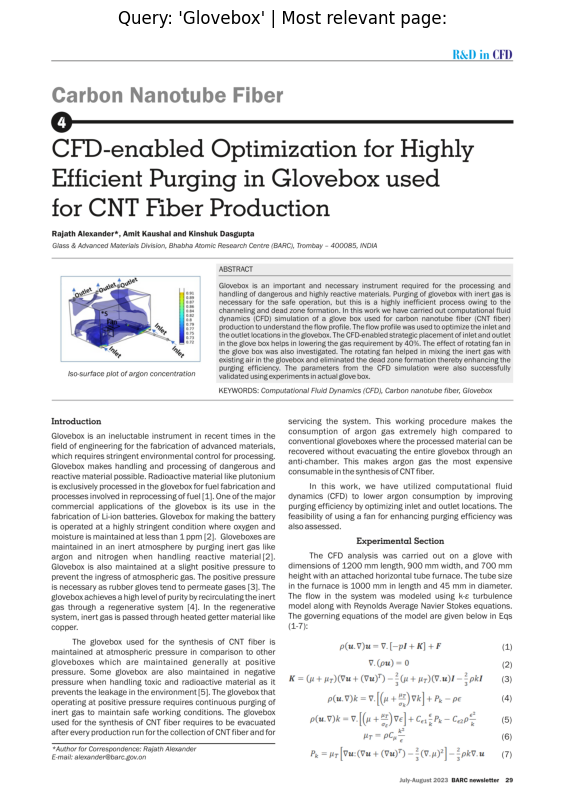

In [42]:
import fitz

# Open PDF and load target page
pdf_path = "/content/BARC NEWSLETTER.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(29 -1) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [43]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [44]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [45]:
query = "Nisargruna"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 163 embeddings: 0.00009 seconds.


(tensor([0.3424, 0.2794, 0.2465, 0.2341, 0.2313], device='cuda:0'),
 tensor([106, 107, 158, 114, 157], device='cuda:0'))

In [46]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 163 embeddings: 0.00006 seconds.
Query: Nisargruna

Results:
Score: 0.3424
Introduction The Nisargruna technology has been developed at Bhabha Atomic
Research Centre (BARC), Mumbai for decentralized processing of the biodegradable
waste. The project has tremendous potential to support the ever-depleting energy
sector by generating fuel and manure required for soil applications. The
technology has evolved in last several years and about 250 such plants are
operative in various parts of the country. Biogas related specific fire safety
regulations are not available in prescribed codes in India [1]. Old National
Building Code (NBC) permits a quantity of 2000 liters of flammable liquid but
the new NBC code [2] and Atomic Energy Regulatory Board (AERB) code suggest that
a large combustible material presence should be situated at outdoor or in a
separate utility building [3]. The Indian Factory Act allows using unlimited
quantity of oil/combustible gas for p

In [47]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [48]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [49]:
pip install huggingface-hub

In [50]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [51]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [52]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [53]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [54]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

In [55]:
input_text = "What is the Glovebox, and what roles do they play?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What is the Glovebox, and what roles do they play?

Prompt (formatted):
<bos><start_of_turn>user
What is the Glovebox, and what roles do they play?<end_of_turn>
<start_of_turn>model



In [56]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    603,    573, 160498,
           3057, 235269,    578,   1212,  16065,    749,    984,   1554, 235336,
            107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    603,    573, 160498,
          3057, 235269,    578,   1212,  16065,    749,    984,   1554, 235336,
           107,    108,    106,   2516,    108,    688, 235319,  12870,   3057,
           688,    109, 235280,  53535,   3057,    603,    476,   2301, 235269,
         36794,  46416,    689,   3741,    674,  12723,    578,  44434,    476,
          8537,    576,  25026, 235265,   1165,    603,  15976,   1644,    576,
           476,  19228,   2893,   1582,    685,   9975,    689,   5998,    578,
           603,   6869,

In [57]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What is the Glovebox, and what roles do they play?<end_of_turn>
<start_of_turn>model
**Glovebox**

A glovebox is a small, enclosed compartment or box that holds and protects a pair of gloves. It is typically made of a durable material such as plastic or metal and is designed to be worn on the hand or finger to provide a secure and comfortable fit.

**Roles of a Glovebox:**

* **Protection:** Gloveboxes provide a physical barrier between the user's hands and the external world, protecting them from dirt, chemicals, and other hazards.
* **Hygiene:** Gloveboxes allow for easy cleaning and disinfection of gloves, reducing the risk of contamination.
* **Organization:** Gloveboxes can be used to store and organize gloves, keeping them organized and easily accessible.
* **Convenience:** Gloveboxes can be attached to clothing or a belt, providing a convenient way to keep gloves close at hand.
* **Ergonomics:** Gloveboxes can be designed to 

In [58]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What is the Glovebox, and what roles do they play?

Output text:
**Glovebox**

A glovebox is a small, enclosed compartment or box that holds and protects a pair of gloves. It is typically made of a durable material such as plastic or metal and is designed to be worn on the hand or finger to provide a secure and comfortable fit.

**Roles of a Glovebox:**

* **Protection:** Gloveboxes provide a physical barrier between the user's hands and the external world, protecting them from dirt, chemicals, and other hazards.
* **Hygiene:** Gloveboxes allow for easy cleaning and disinfection of gloves, reducing the risk of contamination.
* **Organization:** Gloveboxes can be used to store and organize gloves, keeping them organized and easily accessible.
* **Convenience:** Gloveboxes can be attached to clothing or a belt, providing a convenient way to keep gloves close at hand.
* **Ergonomics:** Gloveboxes can be designed to provide a comfortable fit and reduce strain on the hands and w

In [59]:
# questions generated with GPT4
gpt4_questions = [
    "What is  Nisargruna Biogas Plant, and what are its safety evaluations?",
    " how CFD can be used as an effective tool to simulate and understand the fundamental phenomena relevant to solvent extraction",
    "Describe the Computational Model to Simulate Flow in a Vortex Mixer",
    "What is CFD Modeling for Microfluidic Solvent Extraction",
    "Explain the concept of Transmission, Evaporation of Cough Droplets Inside an Elevator"
]

# Manually created question list
manual_questions = [
    "Effect of inlet temperature of molten salt",
    "What is Nisargruna Biogas Plant?",
    "Explain CFD Modeling",
    "What is Glovebox?",
    "Solvent extraction"
]

query_list = gpt4_questions + manual_questions

In [60]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Solvent extraction
[INFO] Time taken to get scores on 163 embeddings: 0.00008 seconds.


(tensor([0.5072, 0.4915, 0.4817, 0.4728, 0.4642], device='cuda:0'),
 tensor([50, 44, 45, 47, 46], device='cuda:0'))

In [92]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is Nisargruna technology?
Answer: The Nisargruna technology has been developed at Bhabha
Atomic Research Centre (BARC), Mumbai for decentralized
processing of the biodegradable waste. The project has
tremendous potential to support the ever-depleting energy
sector by generating fuel and manure required for soil
applications. The technology has evolved in last several years
and about 250 such plants are operative in various parts of the
country.
\nExample 2:
Query: explain glovebox?
Answer:  Glovebox is an ineluctable instrument in recent times in the
field of engineering for the fabrication of advanced materials,
which requires stringent environmental control for processing.
Glovebox makes handling and processing of dangerous and
reactive material possible. Radioactive material like plutonium
is exclusively processed in the glovebox for fuel fabrication and
processes involved in reprocessing of fuel. One of the major
commercial applications of the glovebox is its use in the
fabrication of Li-ion batteries. Glovebox for making the battery
is operated at a highly stringent condition where oxygen and
moisture is maintained at less than 1 ppm
\nExample 3:
Query: What is the importance of CFD in Solvent extraction?
Answer: Solvent extraction is the most important separation process in the nuclear fuel cycle.
Different types of solvent extraction equipment are used in different processes used for
separation and purification of nuclear materials. Computational Fluid Dynamics (CFD) modeling is the most
useful tool to understand the flow physics in solvent extraction equipment. There are different levels of CFD models of
solvent extraction equipment.  CFD modeling can be used
to understand different aspects of microfluidic extraction. It
can be used to find out the kind of flow pattern and size of the
dispersed phase entities that will be generated at a
microfluidic junction for a given liquid-liquid system, geometry
of the microfluidic junction and flow rates of the liquids. It can
also be used to estimate the velocity of the slugs/drops flowing
in the microchannel and to estimate the interphase mass
transfer coefficients
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    #add_generation_prompt = textwrap.fill(add_generation_prompt, width=150)

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)

    # wrapped_prompt = textwrap.fill(prompt, width=150)
    return prompt

In [ ]:
# wrapped_prompt = textwrap.fill(prompt, width=width)
# return wrapped_prompt

In [98]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What is  Nisargruna Biogas Plant, and what are its safety evaluations?
[INFO] Time taken to get scores on 163 embeddings: 0.00006 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What is Nisargruna technology?
Answer: The Nisargruna technology has been developed at Bhabha 
Atomic Research Centre (BARC), Mumbai for decentralized 
processing of the biodegradable waste. The project has 
tremendous potential to support the ever-depleting energy 
sector by generating fuel and manure required for soil 
applications. The technology has evolved in last several years 
and about 250 such plants are operative in various parts of the 
country.

Exampl

In [74]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Effect of inlet temperature of molten salt
RAG answer:
<bos>Sure, here is the answer to the user's query.

The passage that describes the effect of molten salt inlet temperature on the conversion of HI to hydrogen is Fig.7. It indicates that the conversion of HI increases with an increase in the temperature of molten salt inlet.<eos>
CPU times: user 2.35 s, sys: 0 ns, total: 2.35 s
Wall time: 2.35 s


In [75]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [76]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: Describe the Computational Model to Simulate Flow in a Vortex Mixer
[INFO] Time taken to get scores on 163 embeddings: 0.00006 seconds.
Answer:

Sure, here's a summary of the relevant passages from the context about the
Computational Model to Simulate Flow in a Vortex Mixer:  - The model combines
ANN and CFD modeling to overcome the need for computationally expensive
interface-tracking simulations required to capture the vortex shape.   - The ANN
is trained and validated using a large set of experimental data of vortex shape
acquired using high-speed imaging for different parametric conditions and is
used to predict the vortex shape for the cases for which CFD simulations of the
vortex mixer are required.   - The model provides detailed insights into the
flow physics, including turbulence structures in the vortex mixer.   - The model
is validated with the reported PIV data, demonstrating its accuracy and
reliability.
Context items:


[{'page_number': 49,
  'sentence_chunk': 'L iquid phase mixing is a very basic unit operation which is extensively used in chemical processes. Conventionally, liquid phase mixing is achieved by using impellers. However, for several applications passive mixing devices which do not require maintenance are indispensable. A vortex mixer, which is basically a vessel contents of which are mixed by a magnetic stirrer, is one such device and has several potential applications. In a recent study (Sarkar et al.,A novel ANN-CFD model for simulating flow in a vortex mixer, Chem. Eng. Sci.2023, 260: 117819), a numerical model to simulate flow in a vortex mixer is reported. The presence of vortex makes the simulation of the vortex mixer very challenging and requires a model capable of capturing vortex shape (air- liquid interface).',
  'chunk_char_count': 787,
  'chunk_word_count': 125,
  'chunk_token_count': 196.75,
  'embedding': array([-1.68524552e-02, -5.06113432e-02, -1.15751708e-02, -1.6735343